In [27]:
'''
Triple Collocation Method
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from osgeo import gdal
import multiprocessing
from functools import partial

class TripleCollocation(object):
    '''
    About Triple Collocation, see provided .pdf file
    Main Program

    Methods:
    -----------------

    '''

    def __init__(self):
        pass

    def main(self):
        i= 208; j= 293
        RMSE= np.zeros((i*j,3), dtype=np.float16)
        CC= np.zeros((i*j,3), dtype=np.float16)
        ind=0
        for ii in range(i):
            for jj in range(j):
                print('processing (%d,%d)'%(ii,jj))
                ts= self.preprocess(ts)
                ts[ts<0]= 0
                if len(ts)==0 or len(ts)<3:
                    RMSE[ind,:]= -9999
                    CC[ind,:]= -9999
                else:
                    _sig, _r= self.mtc(ts)
                    RMSE[ind,:]= _sig
                    CC[ind,:]= _r
        RMSE_radar= RMSE[:,0].reshape(i,j)
        RMSE_sat= RMSE[:,1].reshape(i,j)
        RMSE_gauge= RMSE[:,2].reshape(i,j)

        CC_radar= CC[:,0].reshape(i,j)
        CC_sat= CC[:,1].reshape(i,j)
        CC_gauge= CC[:,2].reshape(i,j)

        return (RMSE_radar, RMSE_sat, RMSE_gauge), (CC_radar, CC_sat, CC_gauge)

    def parallel(self, cores=6, write=False):
        RMSE= np.zeros((208,293,3), dtype=np.float16)
        CC= np.zeros((208, 293,3), dtype=np.float16)
        # inputs= [(i,j) for i in range(100,130) for j in range(100,140)]
        inputs= [(i,j) for i in range(208) for j in range(293)]
        pool= multiprocessing.Pool(cores)
        results= pool.map(self.single, inputs)
        for r,c,i,j in results:
            RMSE[i,j,:]= r
            CC[i,j,:]= c
        RMSE_radar= RMSE[:,:,0]
        RMSE_sat= RMSE[:,:,1]
        RMSE_gauge= RMSE[:,:,2]

        CC_radar= CC[:,:,0]
        CC_sat= CC[:,:,1]
        CC_gauge= CC[:,:,2]

        if write:
            self.write_geotif('TCresults/rmse_radar.tif',RMSE_radar)
            self.write_geotif('TCresults/rmse_sat.tif',  RMSE_sat)
            self.write_geotif('TCresults/rmse_gauge.tif',RMSE_gauge)

            self.write_geotif('TCresults/cc_radar.tif',CC_radar)
            self.write_geotif('TCresults/cc_sat.tif',  CC_sat)
            self.write_geotif('TCresults/cc_gauge.tif',CC_gauge)

            # self.write_geotif('test.tif', np.zeros((208,293)))

        return RMSE, CC
    
    def site_loop(self, smap, noah, mesonet):
        '''
        This deals with looping within sites
        '''
        # 
        tc_results= pd.DataFrame(index= ['rmse_smap','rmse_noah','rmse_mesonet',
                                         'cc_smap',  'cc_noah',  'cc_mesonet', 'samples'],
                                 columns= smap.columns)
        for i, col in enumerate(smap.columns):
            print('processing %d/%d'%(i,len(smap.columns)))
            try:
                new_df= pd.DataFrame(index= smap.index)
                new_df['SMAP']= smap[col]
                new_df['NOAH']= noah[col]
                new_df['mesonet']= mesonet[col]
                new_df.dropna(axis=0, inplace=True)
                new_df= self.preprocess(new_df)
                rmse, cc= self.mtc(new_df)
                tc_results.loc['rmse_smap', col]= rmse[0]
                tc_results.loc['rmse_noah', col]= rmse[1]
                tc_results.loc['rmse_mesonet', col]= rmse[2]
                tc_results.loc['cc_smap', col]= cc[0]
                tc_results.loc['cc_noah', col]= cc[1]
                tc_results.loc['cc_mesonet', col]= cc[2]
                tc_results.loc['samples', col]= len(new_df.dropna(axis=0))
            except KeyError:
                pass
            
        return tc_results
            

    def single(self, args):
        i,j = args
        print('processing (%d,%d)'%(i,j))
        RMSE= np.zeros(3, dtype=np.float16)
        CC= np.zeros(3, dtype=np.float16)
        ts= PixelTS().singlePixel(i,j)
        ts.radar= ts.radar
        ts.satellite= ts.satellite
        ts= self.preprocess(ts)
        # print('length of ts: ', len(ts))
        if len(ts)==0 or len(ts)<3:
            RMSE[:]= np.array([-9999]*3)
            CC[:]= np.array([-9999]*3)
        else:
            # print(ts.columns)
            _sig, _r= self.mtc(ts)
            RMSE[:]= _sig
            CC[:]= _r

        return RMSE, CC, i,j

    def _ts_tc_single(self, args):
        i,j= args
        print('processing (%d-%d)'%(i,j))
        RMSE= np.zeros((7, 3), dtype=np.float16)
        CC=np.zeros((7, 3), dtype=np.float16)
        ts= PixelTS().singlePixel(i,j)
        # print(ts.radar)
        ts.index= pd.to_datetime(ts.index, format='%Y%m%d%H')
        # print(type(ts.index))
        days= set(ts.index.day.values)
        for i, day in enumerate(days):
            partial_ts= ts[ts.index.day==day]
            partial_ts= self.preprocess(partial_ts)
            if len(partial_ts)==0 or len(partial_ts)<3:
                RMSE[i,:]= np.array([-9999]*3)
                CC[i, :]= np.array([-9999]*3)
            else:
                _sig, _r= self.mtc(partial_ts)
                RMSE[i,:]= _sig
                CC[i, :]= _r

        return i,j, RMSE, CC


    def preprocess(self, data, threshold1=0, threshold2=0.00001):
        # this function drops nan and values between thresholds
        data= data.astype('float32')
        cols= data.columns
        for col in cols:
            # data= data.apply(np.log)
            data=data[data[col]>=threshold2]
            data.clip(lower=threshold2, inplace=True)
            data.dropna(axis=0, inplace=True)

        # print(data)
#         data= data.apply(np.log)
        return data


    def mtc(self, X):
        #check X has shape (time sequence, 3)
        N_boot= 1000
        rmse= np.zeros((N_boot,3))
        cc= np.zeros((N_boot, 3))
        for i in range(N_boot):
            sigma= np.zeros(3)
            r= np.zeros(3)
            sample= self.bootstrap_resample(X, n=N_boot)
            # print(X.columns)

            cov= sample.cov().to_numpy()
            # print(cov)
            # compute RMSE
            if (cov==0).any().any():
                rmse[i,:]=np.nan
                cc[i,:]= np.nan
            else:
                sigma[0]= cov[0,0] - (cov[0,1]*cov[0,2])/(cov[1,2])
                sigma[1]= cov[1,1] - (cov[0,1]*cov[1,2])/(cov[0,2])
                sigma[2]= cov[2,2] - (cov[0,2]*cov[1,2])/(cov[0,1])
                # print(cov[0,0], cov[1,1], cov[2,2])

                sigma[sigma<0]= np.nan
                sigma= sigma**.5

                #compute correlation coefficient
                r[0] = (cov[0,1]*cov[0,2])/(cov[0,0]*cov[1,2])
                r[1] = (cov[0,1]*cov[1,2])/(cov[1,1]*cov[0,2]);
                r[2] = (cov[0,2]*cov[1,2])/(cov[2,2]*cov[0,1]);

                #sign function here?
                r[r<0] = 0.0001
                r[r>1] = 1
                r= r**.5
                r[r<1e-3] = 0

                rmse[i,:]= sigma
                cc[i, :]= r

        return np.nanmean(rmse, axis=0), np.nanmean(cc,axis=0)




    def bootstrap_resample(self, X, n=None):
        """ Bootstrap resample an array_like
        Parameters
        ----------
        X : pandas data frame
          data to resample
        n : int, optional
          length of resampled array, equal to len(X) if n==None
        Results
        -------
        returns X_resamples
        """
        if n == None:
            n = len(X)

        resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
        X_resample = X.iloc[resample_i, :]
        return X_resample

    def write_geotif(self, dst, new_array):
        #read sample
        pth= '../cleaned/gauge4km/ST2gg2017082500.Grb.tif'
        sample= gdal.Open(pth)
        projection= sample.GetProjection()
        trans= sample.GetGeoTransform()
        bands= 1
        driver= gdal.GetDriverByName("GTiff")
        rows, cols= new_array.shape

        outdata = driver.Create(dst, cols, rows, bands, gdal.GDT_Float32)

        outdata.SetGeoTransform(trans)
        outdata.SetProjection(projection)
        outdata.GetRasterBand(bands).WriteArray(new_array)
        outdata.FlushCache()
        outdata = None

'\nTriple Collocation Method\n'

In [2]:
def clean(df, type='smap'):
    
    if type=='smap':
        df.rename(columns= {'Unnamed: 0': 'time'}, inplace=True)
        df.time= pd.to_datetime(df.time, format='%Y%m%d')
        df.sort_values(by='time', inplace=True)
        df.set_index('time', inplace=True)
        
    elif type=='noah':
        df.rename(columns= {'Unnamed: 0': 'time'}, inplace=True)
        df.time= pd.to_datetime(df.time, format='%Y-%m-%d %H:%M:%S')
        df.sort_values(by='time', inplace=True)
        df.set_index('time', inplace=True)
        df.index= df.index.tz_localize('UTC').tz_convert('US/Central').tz_localize(None)
        
    elif type=='meso':
        df= df.drop(0, axis=0)
        df.rename(columns= {'stnm': 'time'}, inplace=True)
        df.time= pd.to_datetime(df.time)
        df.sort_values(by='time', inplace=True)
        df.set_index('time', inplace=True)
        df.index= df.index.tz_localize('UTC').tz_convert('US/Central').tz_localize(None)
    
    
    df[df<0]= np.nan
    
    return df

# 6AM TC

In [101]:
smap= pd.read_csv('SMAP_site_AM.csv')

In [102]:
noah= pd.read_csv('Noah_site.csv')

In [103]:
meso= pd.read_csv('zhendata.csv', skiprows=1)

In [104]:
smap= clean(smap)

In [105]:
noah= clean(noah, 'noah')

In [106]:
meso= clean(meso, 'meso')

In [107]:
slt= pd.date_range(start='2015-04-01 06:00:00', end="2019-07-02 06:00:00", freq='D')

In [108]:
meso_AM= meso.loc[slt,:]

In [109]:
for time in slt:

    try:
        noah_AM.loc[time,:]= noah.loc[time,:]
    except:
        pass
    
    
        

In [110]:
noah_AM= noah_AM.resample('D', how='sum')

/home/ZhiLi/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


In [111]:
meso_AM= meso_AM.resample('D', how='sum')

/home/ZhiLi/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


In [112]:
smap_AM= smap.loc[meso_AM.index,:]

In [113]:
tc= TripleCollocation()

In [114]:
results= tc.site_loop(smap_AM, noah_AM/100., meso_AM)

processing 0/115
processing 1/115
processing 2/115
processing 3/115
processing 4/115
processing 5/115
processing 6/115
processing 7/115
processing 8/115
processing 9/115
processing 10/115
processing 11/115
processing 12/115
processing 13/115
processing 14/115
processing 15/115
processing 16/115
processing 17/115
processing 18/115
processing 19/115
processing 20/115
processing 21/115
processing 22/115
processing 23/115
processing 24/115
processing 25/115
processing 26/115
processing 27/115
processing 28/115
processing 29/115
processing 30/115
processing 31/115
processing 32/115
processing 33/115
processing 34/115
processing 35/115
processing 36/115
processing 37/115
processing 38/115
processing 39/115
processing 40/115
processing 41/115
processing 42/115
processing 43/115
processing 44/115
processing 45/115
processing 46/115
processing 47/115
processing 48/115
processing 49/115
processing 50/115
processing 51/115
processing 52/115
processing 53/115
processing 54/115
processing 55/115
pr

/home/ZhiLi/env/lib/python3.6/site-packages/ipykernel_launcher.py:215: RuntimeWarning: Mean of empty slice


processing 62/115
processing 63/115
processing 64/115
processing 65/115
processing 66/115
processing 67/115
processing 68/115
processing 69/115
processing 70/115
processing 71/115
processing 72/115
processing 73/115
processing 74/115
processing 75/115
processing 76/115
processing 77/115
processing 78/115
processing 79/115
processing 80/115
processing 81/115
processing 82/115
processing 83/115
processing 84/115
processing 85/115
processing 86/115
processing 87/115
processing 88/115
processing 89/115
processing 90/115
processing 91/115
processing 92/115
processing 93/115
processing 94/115
processing 95/115
processing 96/115
processing 97/115
processing 98/115
processing 99/115
processing 100/115
processing 101/115
processing 102/115
processing 103/115
processing 104/115
processing 105/115
processing 106/115
processing 107/115
processing 108/115
processing 109/115
processing 110/115
processing 111/115
processing 112/115
processing 113/115
processing 114/115


In [68]:
#add site info inside
results.to_csv('TC_results_AM.csv')

# 6PM TC

In [75]:
smap= pd.read_csv('SMAP_site_PM.csv')
noah= pd.read_csv('Noah_site.csv')
meso= pd.read_csv('zhendata.csv', skiprows=1)
smap= clean(smap)
noah= clean(noah, 'noah')
meso= clean(meso, 'meso')

In [76]:
slt= pd.date_range(start='2015-04-01 18:00:00', end="2019-07-02 18:00:00", freq='D')

In [77]:
meso_PM= meso.loc[slt,:].resample('D', how='sum')
noah_PM= noah.loc[slt,:].resample('D', how='sum')

/home/ZhiLi/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.
/home/ZhiLi/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  


In [78]:
smap_PM= smap.loc[meso_PM.index,:]

In [79]:
results= tc.site_loop(smap_PM, noah_PM/100., meso_PM)

processing 0/115
processing 1/115
processing 2/115
processing 3/115
processing 4/115
processing 5/115
processing 6/115
processing 7/115
processing 8/115
processing 9/115
processing 10/115
processing 11/115
processing 12/115
processing 13/115
processing 14/115
processing 15/115
processing 16/115
processing 17/115
processing 18/115
processing 19/115
processing 20/115
processing 21/115
processing 22/115
processing 23/115
processing 24/115
processing 25/115
processing 26/115
processing 27/115
processing 28/115
processing 29/115
processing 30/115
processing 31/115
processing 32/115
processing 33/115
processing 34/115
processing 35/115
processing 36/115
processing 37/115
processing 38/115
processing 39/115
processing 40/115
processing 41/115
processing 42/115
processing 43/115
processing 44/115
processing 45/115
processing 46/115
processing 47/115
processing 48/115
processing 49/115
processing 50/115
processing 51/115
processing 52/115
processing 53/115
processing 54/115
processing 55/115
pr

/home/ZhiLi/env/lib/python3.6/site-packages/ipykernel_launcher.py:215: RuntimeWarning: Mean of empty slice


processing 62/115
processing 63/115
processing 64/115
processing 65/115
processing 66/115
processing 67/115
processing 68/115
processing 69/115
processing 70/115
processing 71/115
processing 72/115
processing 73/115
processing 74/115
processing 75/115
processing 76/115
processing 77/115
processing 78/115
processing 79/115
processing 80/115
processing 81/115
processing 82/115
processing 83/115
processing 84/115
processing 85/115
processing 86/115
processing 87/115
processing 88/115
processing 89/115
processing 90/115
processing 91/115
processing 92/115
processing 93/115
processing 94/115
processing 95/115
processing 96/115
processing 97/115
processing 98/115
processing 99/115
processing 100/115
processing 101/115
processing 102/115
processing 103/115
processing 104/115
processing 105/115
processing 106/115
processing 107/115
processing 108/115
processing 109/115
processing 110/115
processing 111/115
processing 112/115
processing 113/115
processing 114/115


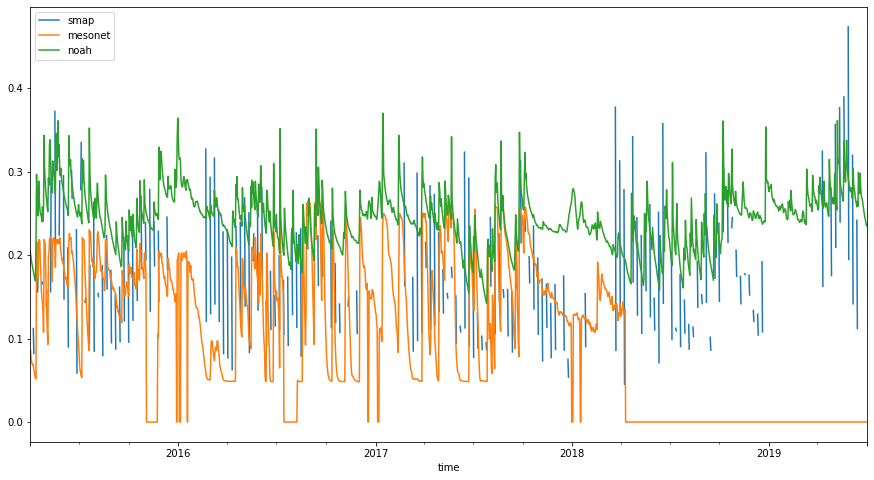

In [41]:
plt.figure(figsize=(15,8))
smap_PM.loc[:, '35'].plot(label='smap')
meso_PM.loc[:, '35'].plot(label='mesonet')
(noah_PM.loc[:, '35']/100.).plot(label='noah')
plt.legend()

In [50]:
results.to_csv('TC_results_PM.csv')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f61ca4bbba8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f61ca4be400>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f61ca4bb828>,
 'medians': [<matplotlib.lines.Line2D at 0x7f61ca4be9e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f61ca4bed30>,
 'means': []}

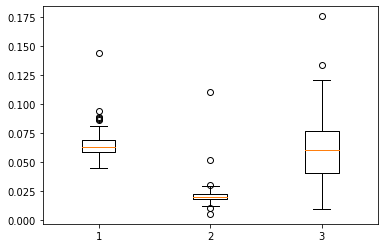

In [46]:
plt.boxplot([results.iloc[0,:], results.iloc[1,:], results.iloc[2,:].dropna()])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f61ca40c278>,
 'caps': [<matplotlib.lines.Line2D at 0x7f61ca40c908>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f61ca47df28>,
 'medians': [<matplotlib.lines.Line2D at 0x7f61ca40cf98>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f61ca415320>,
 'means': []}

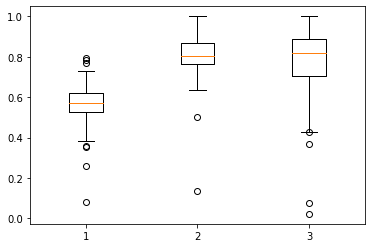

In [47]:
plt.boxplot([results.iloc[3,:], results.iloc[4,:], results.iloc[5,:].dropna()])

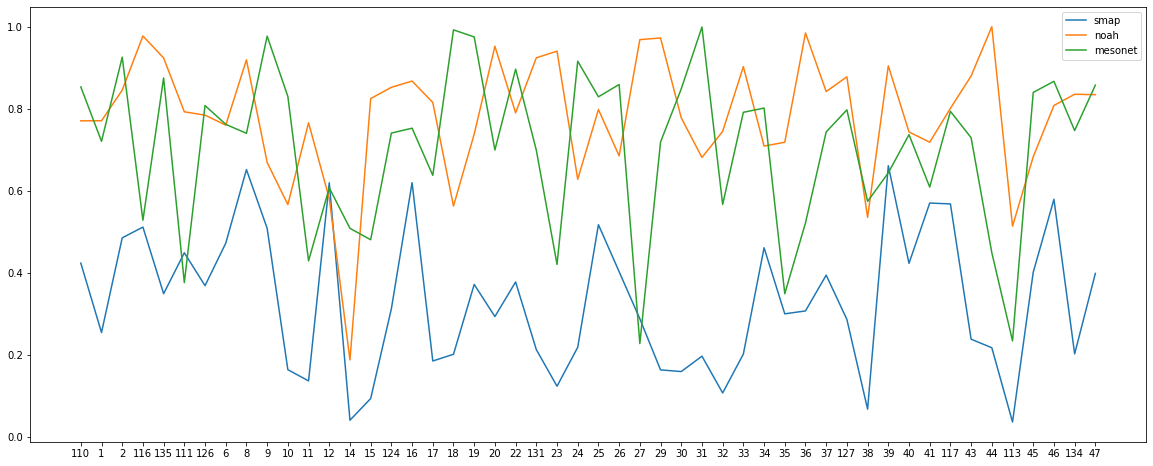

In [67]:
plt.figure(figsize=(20,8))
plt.plot(results.iloc[3,:50].dropna(), label='smap')
plt.plot(results.iloc[4,:50].dropna(), label='noah')
plt.plot(results.iloc[5,:50].dropna(), label='mesonet')
plt.legend()

In [227]:

tc_results= pd.DataFrame(index= ['rmse_smap','rmse_noah','rmse_mesonet',
                                         'cc_smap',  'cc_noah',  'cc_mesonet'], columns= smap.columns)
new_df= pd.DataFrame(index= smap.index)
new_df['SMAP']= smap.loc[:, '2']

new_df['mesonet']= meso.loc[:, '2']

new_df['NOAH']= noah.loc[:, '2']/100.
new_df= preprocess(new_df)
rmse, cc= mtc(new_df)
print(rmse, cc)


[0.38927452 0.149723   0.08601649] [0.5114297  0.92775652 0.89027376]


In [165]:
tc_results

,110,1,2,116,135,111,126,6,8,9,...,99,100,101,102,132,104,105,106,107,108
rmse_smap,NaN,NaN,0.389522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rmse_noah,0.150412,0.150412,0.150412,0.150412,0.150412,0.150412,0.150412,0.150412,0.150412,0.150412,...,0.150412,0.150412,0.150412,0.150412,0.150412,0.150412,0.150412,0.150412,0.150412,0.150412
rmse_mesonet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc_smap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc_noah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc_mesonet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
def preprocess(data, threshold1=0, threshold2=0.01):
        # this function drops nan and values between thresholds
        data= data.astype('float32')
        cols= data.columns
        for col in cols:
            # data= data.apply(np.log)
            data=data[data[col]>=threshold2]
            data.clip(lower=threshold2, inplace=True)
            # data.dropna(inplace=True)
        # print(data)
        data= data.apply(np.log)
        return data
    
def mtc(X):
        #check X has shape (time sequence, 3)
        N_boot= 100
        rmse= np.zeros((N_boot,3))
        cc= np.zeros((N_boot, 3))
        for i in range(N_boot):
            sigma= np.zeros(3)
            r= np.zeros(3)
            sample= bootstrap_resample(X, n=N_boot)
            # print(X.columns)
            cov= sample.cov().to_numpy()
            # print(cov)
            # compute RMSE
            if (cov==0).any().any():
                rmse[i,:]=np.nan
                cc[i,:]= np.nan
            else:
                sigma[0]= cov[0,0] - (cov[0,1]*cov[0,2])/(cov[1,2])
                sigma[1]= cov[1,1] - (cov[0,1]*cov[1,2])/(cov[0,2])
                sigma[2]= cov[2,2] - (cov[0,2]*cov[1,2])/(cov[0,1])
                # print(cov[0,0], cov[1,1], cov[2,2])

                sigma[sigma<0]= np.nan
                sigma= sigma**.5

                #compute correlation coefficient
                r[0] = (cov[0,1]*cov[0,2])/(cov[0,0]*cov[1,2])
                r[1] = (cov[0,1]*cov[1,2])/(cov[1,1]*cov[0,2]);
                r[2] = (cov[0,2]*cov[1,2])/(cov[2,2]*cov[0,1]);

                #sign function here?
                r[r<0] = 0.0001
                r[r>1] = 1
                r= r**.5
                r[r<1e-3] = 0

                rmse[i,:]= sigma
                cc[i, :]= r

        return np.nanmean(rmse, axis=0), np.nanmean(cc,axis=0)
    
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : pandas data frame
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if n == None:
        n = len(X)

    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X.iloc[resample_i, :]
    return X_resample


In [115]:
siteDF= pd.read_excel('/home/ZhiLi/soilmoisture/Mesonet_Stations_info.xlsx')

In [116]:
siteDF.stnm= siteDF.stnm.values.astype(str)
siteDF.set_index('stnm', inplace=True)

In [117]:
siteInfo= pd.DataFrame(index= siteDF.index.values.astype(str))

In [118]:
siteDF['cc_smap']= results.T.loc[:,'cc_smap']
siteDF['cc_mesonet']= results.T.loc[:,'cc_mesonet']
siteDF['cc_noah']= results.T.loc[:,'cc_noah']
siteDF['rmse_smap']= results.T.loc[:,'rmse_smap']
siteDF['rmse_mesonet']= results.T.loc[:,'rmse_mesonet']
siteDF['rmse_noah']= results.T.loc[:,'rmse_noah']
siteDF['sampleSize']= results.T.loc[:, 'samples']

In [120]:
siteDF.to_csv('TC_results_AM.csv')

# Raster TC

## Read in data

In [1]:
import pygrib
import h5py
import affine
from multiprocessing import Pool
import time

In [2]:
def getIndex(lons,lats, lon, lat):
    col= np.where(abs(lons[0,:] - lon)== np.nanmin(abs(lons[0,:] - lon)))[0]
    row= np.where(abs(lats[:,0] - lat) == np.nanmin(abs(lats[:, 0] - lat)))[0]
                  
    return row, col

def thread(lon, lat, time):
    try:
        fname= '/media/scratch/ZhiLi/SMAP/SMAP_L3_SM_P_E_%s_R16510_001.h5'%time.strftime('%Y%m%d')
        with h5py.File(fname, 'r') as h5:
            soil= h5['Soil_Moisture_Retrieval_Data_AM/soil_moisture'][:]
            lons= h5['Soil_Moisture_Retrieval_Data_AM/longitude'][:]
            lats= h5['Soil_Moisture_Retrieval_Data_AM/latitude'][:]

        row, col= getIndex(lons, lats, lon, lat)
        val= soil[row, col][0]
    except OSError:
        val= np.nan

    return time, val

def SMAPretrieval(lon, lat, periods):

        
    df= pd.DataFrame(index= periods, columns=['smap'])
    func= partial(thread, lon, lat)
    with Pool(4) as pool:
        results= pool.map(func, periods)
    for result in results:
        df.loc[result[0], 'smap']= result[1]
        
    return df
            
def NOAHretrieval(lon, lat, periods):
    df= pd.DataFrame(index=periods, columns=['noah'])
    for time in periods:
        fname= 'data/NLDAS_NOAH0125_H.A%s.%s.002.grb.SUB.grb'%(time.strftime('%Y%m%d'),
                                                              time.strftime('%H%M'))
        try:
            gribs= pygrib.open(fname)
            grib= gribs.message(4)
            lats, lons= grib.latlons()
            arr= grib.values
            soilDF= pd.DataFrame()
            gribs.close()
            datetime= fname.split('.')[1][1:]+fname.split('.')[2]

            row, col= getIndex(lons, lats, lon, lat)

            df.loc[time, 'noah']= arr[row, col][0].astype(np.float32)
        except OSError:
            pass

    return df

    
def MESOretrieval(lon, lat, periods):

    df= pd.DataFrame(index= periods, columns= ['meso'])
    for time in periods:
        try:
#             fname= '/media/scratch/ZhiLi/OK_mesonet/%s.tif'%time.strftime('%Y%m%d%H%M%S')
#           ========self-gridded numpy===========
            fname= 'regridedMESO/%s.npy'%time.strftime('%Y%m%d%H')
            arr= np.load(fname)
            lons= arr[2]
            lats= arr[1]
            row, col= getIndex(lons, lats, lon, lat)
            
            df.loc[time, 'meso']= arr[-1,row, col][0].astype(np.float32)
#             =============OSU gridded raster==============
#             fname= '/media/scratch/ZhiLi/Meso_gridded/%s.tif'%time.strftime('%Y%m%d%H')
#             raster= gdal.Open(fname)
#             geo= raster.GetGeoTransform()
#             xsize= raster.RasterXSize
#             ysize= raster.RasterYSize
#             lons= np.arange(geo[0], geo[0]+xsize*geo[1], geo[1])
#             lats= np.arange(geo[3], geo[3]+ysize*geo[-1], geo[-1])
#             lons, lats= np.meshgrid(lons, lats)
#             row, col= getIndex(lons, lats, lon, lat)
#             df.loc[time, 'meso']= raster.ReadAsArray()[row, col][0].astype(np.float32)
        except AttributeError:
            pass
    
    return df
    
def pixelTSretrieval(lon,lat):
    periods= pd.date_range('20150901060000', '20190702060000', freq='D')
    df= pd.DataFrame(index= periods, columns=['smap','noah','meso'])
    smap= SMAPretrieval(lon, lat, periods).astype(float)
    noah= NOAHretrieval(lon, lat, periods).astype(float)/100.
    meso= MESOretrieval(lon, lat, periods).astype(float)
    df['smap']= smap
    df['noah']= noah
    df['meso']= meso
    df[df<0]= np.nan
    return df
    RMSE, CC= mtc(df.dropna())
    
    return RMSE, CC
    
    
def main():
    sample= gdal.Open('/media/scratch/ZhiLi/Meso_gridded/2015090106.tif')
    
    nlon, nlat= sample.RasterXSize, sample.RasterYSize
    geo= sample.GetGeoTransform()
    lons= geo[0]+ np.arange(nlon)*geo[1]
    lats= geo[3]+ np.arange(nlat)*geo[-1]
    RMSE_field= np.zeros((3,nlat, nlon))
    CC_field= np.zeros((3,nlat, nlon))
    for n, lon in enumerate(lons):
        for m, lat in enumerate(lats):
            print('%d/%d'%(m*n, len(lons)*len(lats)))
            RMSE, CC= pixelTSretrieval(lon, lat) 
            RMSE_field[:, m, n]= RMSE
            CC_field[:, m, n]= CC
            
    return RMSE_field, CC_field

In [3]:
SMAP_path= '/media/scratch/ZhiLi/SMAP/'
NOAH_path= '/media/scratch/ZhiLi/Noah_6AM'
# MESO_path= '/media/scratch/ZhiLi/OK_mesonet'
MESO_path= 'regriddedMESO'

In [20]:
sample= gdal.Open('/media/scratch/ZhiLi/Meso_gridded/2015090106.tif')

nlon, nlat= sample.RasterXSize, sample.RasterYSize
geo= sample.GetGeoTransform()
lons_ref= geo[0]+ np.arange(nlon)*geo[1]
lats_ref= geo[3]+ np.arange(nlat)*geo[-1]

In [5]:
fname= '/media/scratch/ZhiLi/SMAP/SMAP_L3_SM_P_E_20180601_R16510_001.h5'
with h5py.File(fname, 'r') as h5:
    print(h5['Soil_Moisture_Retrieval_Data_AM'].keys())

<KeysViewHDF5 ['EASE_column_index', 'EASE_row_index', 'albedo', 'boresight_incidence', 'bulk_density', 'clay_fraction', 'freeze_thaw_fraction', 'grid_surface_status', 'latitude', 'latitude_centroid', 'longitude', 'longitude_centroid', 'radar_water_body_fraction', 'retrieval_qual_flag', 'roughness_coefficient', 'soil_moisture', 'soil_moisture_error', 'static_water_body_fraction', 'surface_flag', 'surface_temperature', 'surface_water_fraction_mb_h', 'surface_water_fraction_mb_v', 'tb_3_corrected', 'tb_4_corrected', 'tb_h_corrected', 'tb_h_uncorrected', 'tb_qual_flag_3', 'tb_qual_flag_4', 'tb_qual_flag_h', 'tb_qual_flag_v', 'tb_time_seconds', 'tb_time_utc', 'tb_v_corrected', 'tb_v_uncorrected', 'vegetation_opacity', 'vegetation_water_content']>


In [7]:
import h5py

In [9]:
fname='/media/scratch/ZhiLi/SMAP_L4/SMAP_L4_SM_gph_20170406T133000_Vv5012_001.h5'
h5= h5py.File(fname)

In [41]:
h5['Metadata/GridSpatialRepresentation/Latitude'].keys()

<KeysViewHDF5 []>

In [44]:
h5['Metadata/Extent']

<HDF5 group "/Metadata/Extent" (0 members)>

In [60]:
smap_lons= h5['cell_lon'][:]
smap_lats= h5['cell_lat'][:]



In [28]:
h5['Geophysical_Data/sm_surface'][:].shape

(1624, 3856)

In [45]:
h5.keys()

<KeysViewHDF5 ['EASE2_global_projection', 'Geophysical_Data', 'Metadata', 'cell_column', 'cell_lat', 'cell_lon', 'cell_row', 'time', 'x', 'y']>

In [56]:
ulcorner= (-102.938, 36.938)
llcorner= (-102.938, 33.688)
urcorner= (-94.438, 36.938)
lrcorner= (-94.438, 33.688)

In [73]:
1392932- 1246313

146619

In [78]:
69*27*73

135999

In [69]:
lons_ref.shape

(69,)

In [70]:
lats_ref.shape

(27,)

In [83]:
lons_ref

array([-102.938, -102.813, -102.688, -102.563, -102.438, -102.313,
       -102.188, -102.063, -101.938, -101.813, -101.688, -101.563,
       -101.438, -101.313, -101.188, -101.063, -100.938, -100.813,
       -100.688, -100.563, -100.438, -100.313, -100.188, -100.063,
        -99.938,  -99.813,  -99.688,  -99.563,  -99.438,  -99.313,
        -99.188,  -99.063,  -98.938,  -98.813,  -98.688,  -98.563,
        -98.438,  -98.313,  -98.188,  -98.063,  -97.938,  -97.813,
        -97.688,  -97.563,  -97.438,  -97.313,  -97.188,  -97.063,
        -96.938,  -96.813,  -96.688,  -96.563,  -96.438,  -96.313,
        -96.188,  -96.063,  -95.938,  -95.813,  -95.688,  -95.563,
        -95.438,  -95.313,  -95.188,  -95.063,  -94.938,  -94.813,
        -94.688,  -94.563,  -94.438])

In [81]:
np.diff(lons_ref)

array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125])

In [61]:
getIndex(smap_lons.reshape(-1), smap_lats.reshape(-1), llcorner[0], llcorner[1])

1392841

In [62]:
getIndex(smap_lons.reshape(-1), smap_lats.reshape(-1), ulcorner[0], ulcorner[1])

1246313

In [63]:
getIndex(smap_lons.reshape(-1), smap_lats.reshape(-1), lrcorner[0], lrcorner[1])

1392932

In [64]:
getIndex(smap_lons.reshape(-1), smap_lats.reshape(-1), urcorner[0], urcorner[1])

1246404

In [101]:
def getIndex(lons,lats, lon, lat):
                  
    return np.argmin((lons-lon)**2+(lats-lat)**2)

def get_SMAP_L4(lons_ref, lats_ref, time):
    fname='/media/scratch/ZhiLi/SMAP_L4/SMAP_L4_SM_gph_%s_Vv5012_001.h5'%time.strftime('%Y%m%dT%H3000')
    lons,lats= np.meshgrid(lons_ref, lats_ref)
    lons= lons.reshape(-1)
    lats= lats.reshape(-1)
    with h5py.File(fname, 'r') as h5:
        sm= h5['Geophysical_Data/sm_surface'][:].reshape(-1)[1246313:1392932]
        x= h5['cell_lon'][:].reshape(-1)[1246313:1392932]
        y= h5['cell_lat'][:].reshape(-1)[1246313:1392932]
#         x,y= np.meshgrid(x,y)
#     x=x.reshape(-1); y=y.reshape(-1)
    ilocs= [getIndex(x,y,lon,lat) for (lon, lat) in zip(lons, lats)]
    
    return lons.reshape(-1), lats.reshape(-1), sm.reshape(-1)[ilocs]
        
def aggregate(lons_ref, lats_ref):
    dates= pd.date_range('20150501073000', '20190701193000', freq='12H')
    SM= []
    for date in dates:
        try:
            lons,lats,sm= get_SMAP_L4(lons_ref, lats_ref, date)
        except OSError:
            sm=np.ones((1863))*-9999.
        SM.append(sm)
    SM= np.stack(SM)
    np.save('SMAP_L4_0222.npy', SM)
    

In [102]:
aggregate(lons_ref, lats_ref)

In [109]:
lons,lats,sm= get_SMAP_L4(lons_ref, lats_ref, pd.to_datetime('20170412193000'))

In [116]:
sm= np.load('SMAP_L4_0222.npy')

In [105]:
df= pd.DataFrame(index= pd.date_range('20150501073000', '20190701193000', freq='12H'))


In [110]:
lons.shape

(1863,)

In [107]:
sm.shape

(3046, 1863)

In [115]:
sm.shape

(1863,)

In [117]:
iloc=0
for i in range(len(lons)):
    df.loc[:, '(%.4f,%.4f)'%(lons[i],lats[i])]= sm[:, i]

In [119]:
df.to_csv('smap_20210222.csv')

In [99]:
pd.date_range('20150501073000', '20190701193000', freq='12H')

DatetimeIndex(['2015-05-01 07:30:00', '2015-05-01 19:30:00',
               '2015-05-02 07:30:00', '2015-05-02 19:30:00',
               '2015-05-03 07:30:00', '2015-05-03 19:30:00',
               '2015-05-04 07:30:00', '2015-05-04 19:30:00',
               '2015-05-05 07:30:00', '2015-05-05 19:30:00',
               ...
               '2019-06-27 07:30:00', '2019-06-27 19:30:00',
               '2019-06-28 07:30:00', '2019-06-28 19:30:00',
               '2019-06-29 07:30:00', '2019-06-29 19:30:00',
               '2019-06-30 07:30:00', '2019-06-30 19:30:00',
               '2019-07-01 07:30:00', '2019-07-01 19:30:00'],
              dtype='datetime64[ns]', length=3046, freq='12H')

In [1]:
def thread(time):
    global geo
    
    try:
#         fname= '/media/scratch/ZhiLi/SMAP/SMAP_L3_SM_P_E_%s_R16510_001.h5'%time.strftime('%Y%m%d')
        fname='/media/scratch/ZhiLi/SMAP_L4/SMAP_L4_SM_gph_%s_Vv5012_001.h5'%time.strftime('%Y%m%dT%H3000')
        with h5py.File(fname, 'r') as h5:
            soil= h5['Soil_Moisture_Retrieval_Data_AM/soil_moisture'][:]
            lons= h5['Soil_Moisture_Retrieval_Data_AM/longitude'][:]
            lats= h5['Soil_Moisture_Retrieval_Data_AM/latitude'][:]
        a= affine.Affine.from_gdal(-179.95, 0.09,0, 84.66,0, -0.70)
#         print(a)
        ilocs= np.array([~a * (lon, lat) for lon in lons_ref for lat in lats_ref])
        rows, cols= ilocs.astype(int)[:,1],ilocs.astype(int)[:,0]
        val= soil[rows, cols]
    except OSError:
        val= np.zeros(len(lons_ref)*len(lats_ref)) * -9999.

    return time, val

def NOAHretrieval(time):

    fname= 'data/NLDAS_NOAH0125_H.A%s.%s.002.grb.SUB.grb'%(time.strftime('%Y%m%d'),
                                                          time.strftime('%H%M'))
    try:
        gribs= pygrib.open(fname)
        grib= gribs.message(4)
        lats, lons= grib.latlons()
        arr= grib.values
        a= affine.Affine.from_gdal(lons[0,0], lons[0,1]- lons[0,0],0, lats[0,0],0, lats[1,0]- lats[0,0])
        ilocs= np.array([~a * (lon, lat) for lon in lons_ref for lat in lats_ref])
        rows, cols= ilocs.astype(int)[:,1],ilocs.astype(int)[:,0]

        row, col= getIndex(lons, lats, lon, lat)

        val= arr[rows, cols]
    except OSError:
        val= np.zeros(len(lons_ref)*len(lats_ref)) * -9999.

    return val

In [7]:
_df= SMAPretrieval(-96,34, periods)

In [6]:
periods= pd.date_range('20150401060000', '20190702060000', freq='D')
__df= MESOretrieval(-96,34, periods)

In [9]:
_df[_df<0]= np.nan
_df.dropna().count()

smap    460
dtype: int64

In [14]:
np.unique(np.array([m%4+1 for m in _df.dropna().index.month]), return_counts=True)

(array([1, 2, 3, 4]), array([126, 116, 119,  99]))

In [17]:
lons_refd

NameError: name 'lons_ref' is not defined

In [27]:
periods= pd.date_range('20150901060000', '20190702060000', freq='D')
df_noah= pd.DataFrame(index=periods)
i=0
for lon in lons_ref:
    for lat in lats_ref:
        print('%d/%d'%(i, len(lons_ref)*len(lats_ref)))
        df_noah[str(tuple((lon,lat)))] = NOAHretrieval(lon, lat,periods)
        i+=1

0/1863
1/1863
2/1863
3/1863


KeyboardInterrupt: 

In [35]:
df_noah= pd.DataFrame(index=periods, columns=[(lon, lat) for lon in lons_ref for lat in lats_ref])
i=0
for i,time in enumerate(periods):
    print('%d/%d'%(i, len(lons_ref)*len(lats_ref)))
    arr = NOAHretrieval(time)
    df_noah.iloc[i,:]= arr
    
    i+=1

0/1863
1/1863
2/1863
3/1863
4/1863
5/1863
6/1863
7/1863
8/1863
9/1863
10/1863
11/1863
12/1863
13/1863
14/1863
15/1863
16/1863
17/1863
18/1863
19/1863
20/1863
21/1863
22/1863
23/1863
24/1863
25/1863
26/1863
27/1863
28/1863
29/1863
30/1863
31/1863
32/1863
33/1863
34/1863
35/1863
36/1863
37/1863
38/1863
39/1863
40/1863
41/1863
42/1863
43/1863
44/1863
45/1863
46/1863
47/1863
48/1863
49/1863
50/1863
51/1863
52/1863
53/1863
54/1863
55/1863
56/1863
57/1863
58/1863
59/1863
60/1863
61/1863
62/1863
63/1863
64/1863
65/1863
66/1863
67/1863
68/1863
69/1863
70/1863
71/1863
72/1863
73/1863
74/1863
75/1863
76/1863
77/1863
78/1863
79/1863
80/1863
81/1863
82/1863
83/1863
84/1863
85/1863
86/1863
87/1863
88/1863
89/1863
90/1863
91/1863
92/1863
93/1863
94/1863
95/1863
96/1863
97/1863
98/1863
99/1863
100/1863
101/1863
102/1863
103/1863
104/1863
105/1863
106/1863
107/1863
108/1863
109/1863
110/1863
111/1863
112/1863
113/1863
114/1863
115/1863
116/1863
117/1863
118/1863
119/1863
120/1863
121/1863
122/1863
123

In [23]:
df_smap= pd.DataFrame(index=periods, columns=[(lon, lat) for lon in lons_ref for lat in lats_ref])
i=0
for i,time in enumerate(periods):
    print('%d/%d'%(i, len(lons_ref)*len(lats_ref)))
    _, arr = thread(time)
    df_smap.iloc[i,:]= arr
    
    i+=1

0/1863
1/1863
2/1863
3/1863
4/1863
5/1863
6/1863
7/1863
8/1863
9/1863
10/1863
11/1863
12/1863
13/1863
14/1863
15/1863
16/1863
17/1863
18/1863
19/1863
20/1863
21/1863
22/1863
23/1863
24/1863
25/1863
26/1863
27/1863
28/1863
29/1863
30/1863
31/1863
32/1863
33/1863
34/1863
35/1863
36/1863
37/1863
38/1863
39/1863
40/1863
41/1863
42/1863
43/1863
44/1863
45/1863
46/1863
47/1863
48/1863
49/1863
50/1863
51/1863
52/1863
53/1863
54/1863
55/1863
56/1863
57/1863
58/1863
59/1863
60/1863
61/1863
62/1863
63/1863
64/1863
65/1863
66/1863
67/1863
68/1863
69/1863
70/1863
71/1863
72/1863
73/1863
74/1863
75/1863
76/1863
77/1863
78/1863
79/1863
80/1863
81/1863
82/1863
83/1863
84/1863
85/1863
86/1863
87/1863
88/1863
89/1863
90/1863
91/1863
92/1863
93/1863
94/1863
95/1863
96/1863
97/1863
98/1863
99/1863
100/1863
101/1863
102/1863
103/1863
104/1863
105/1863
106/1863
107/1863
108/1863
109/1863
110/1863
111/1863
112/1863
113/1863
114/1863
115/1863
116/1863
117/1863
118/1863
119/1863
120/1863
121/1863
122/1863
123

In [24]:
df_smap

,"(-102.938, 33.688)","(-102.938, 33.813)","(-102.938, 33.938)","(-102.938, 34.063)","(-102.938, 34.188)","(-102.938, 34.313)","(-102.938, 34.438)","(-102.938, 34.563)","(-102.938, 34.688)","(-102.938, 34.813)","(-102.938, 34.938)","(-102.938, 35.063)","(-102.938, 35.188)","(-102.938, 35.313)","(-102.938, 35.438)",...,"(-94.438, 35.188)","(-94.438, 35.313)","(-94.438, 35.438)","(-94.438, 35.563)","(-94.438, 35.688)","(-94.438, 35.813)","(-94.438, 35.938)","(-94.438, 36.063)","(-94.438, 36.188)","(-94.438, 36.313)","(-94.438, 36.438)","(-94.438, 36.563)","(-94.438, 36.688)","(-94.438, 36.813)","(-94.438, 36.938)"
2015-04-01 06:00:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2015-04-02 06:00:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2015-04-03 06:00:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2015-04-04 06:00:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2015-04-05 06:00:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-28 06:00:00,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,...,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
2019-06-29 06:00:00,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,...,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
2019-06-30 06:00:00,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,...,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
2019-07-01 06:00:00,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,...,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


In [38]:
(df_noah/100).to_csv('noah_20200523.csv')

In [25]:
df_smap.to_csv('smap_20200523.csv')

In [10]:
df_meso.to_csv('mesonet_20200523.csv')

In [17]:
periods= pd.date_range('20150901060000', '20190702060000', freq='D')
_df= NOAHretrieval(-96,34, periods)

In [18]:
__df= MESOretrieval(-96,34, periods)

In [19]:
___df= SMAPretrieval(-96,34, periods)

In [21]:
_df[_df<0]=np.nan
__df[__df<0]=np.nan
___df[___df<0]=np.nan

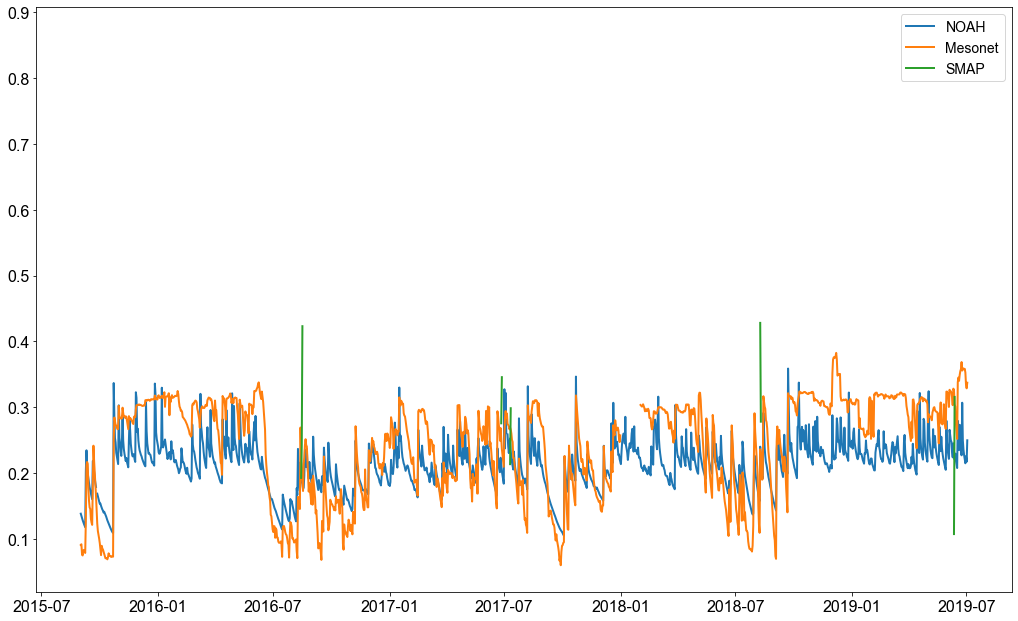

In [24]:
plt.plot(_df/100., label='NOAH')
plt.plot(__df, label='Mesonet')
plt.plot(___df, label='SMAP')
plt.legend()

In [40]:
start= time.time()
results= pixelTSretrieval(-96,34)
end= time.time()
print('one pixel costs %.2f minutes'%((end-start)/60.))

one pixel costs 1.74 minutes


In [44]:
mtc(results.dropna())

(array([0.09445269, 2.1019358 , 0.05121253]),
 array([0.20077285, 0.86349251, 0.78807408]))

In [37]:
RMSE, CC= main()

0/1863


IndexError: positional indexers are out-of-bounds

In [3]:
sample= gdal.Open('/media/scratch/ZhiLi/Meso_gridded/2015090106.tif')
nlon, nlat= sample.RasterXSize, sample.RasterYSize
geo= sample.GetGeoTransform()
lons= geo[0]+ np.arange(nlon)*geo[1]
lats= geo[3]+ np.arange(nlat)*geo[-1]

In [9]:
arr= np.load('regridedMESO/2015040118.npy')

In [13]:
arr[2,0,:]

array([-102.93049622, -102.83713531, -102.74377441, -102.65041351,
       -102.55705261, -102.46369171, -102.37033081, -102.27696991,
       -102.18360901, -102.09024811, -101.99688721, -101.90352631,
       -101.81016541, -101.7168045 , -101.6234436 , -101.5300827 ,
       -101.4367218 , -101.3433609 , -101.25      , -101.1566391 ,
       -101.0632782 , -100.9699173 , -100.8765564 , -100.7831955 ,
       -100.68983459, -100.59647369, -100.50311279, -100.40975189,
       -100.31639099, -100.22303009, -100.12966919, -100.03630829,
        -99.94294739,  -99.84958649,  -99.75622559,  -99.66286469,
        -99.56950378,  -99.47614288,  -99.38278198,  -99.28942108,
        -99.19606018,  -99.10269928,  -99.00933838,  -98.91597748,
        -98.82261658,  -98.72925568,  -98.63589478,  -98.54253387,
        -98.44917297,  -98.35581207,  -98.26245117,  -98.16909027,
        -98.07572937,  -97.98236847,  -97.88900757,  -97.79564667,
        -97.70228577,  -97.60892487,  -97.51556396,  -97.42219

In [5]:
import h5py

In [8]:
with h5py.File('RMSE_raster_AM.h5', 'w') as h5:
    h5.create_dataset('lons', data=lons)
    h5.create_dataset('lats', data=lats)
    h5.create_dataset('SMAP', data=arr[0])
    h5.create_dataset('Noah', data=arr[1])
    h5.create_dataset('Meso', data=arr[2])

<HDF5 dataset "lons": shape (69,), type "<f8">

<HDF5 dataset "lats": shape (27,), type "<f8">

<HDF5 dataset "SMAP": shape (38, 92), type "<f8">

<HDF5 dataset "Noah": shape (38, 92), type "<f8">

<HDF5 dataset "Meso": shape (38, 92), type "<f8">

In [2]:
arr.shape

(3, 38, 92)